**Table of contents**<a id='toc0_'></a>    
- [Data Collection](#toc1_1_)    
      - [Small task: Process dataframe structure](#toc1_1_1_1_)    
- [Feature Engineering](#toc2_)    
    - [Technical Analysis](#toc2_1_1_)    
      - [RSI Index](#toc2_1_1_1_)    
      - [MACD Index](#toc2_1_1_2_)    
      - [MFI Index](#toc2_1_1_3_)    
      - [Stochastic Oscillator](#toc2_1_1_4_)    
    - [Plot the NFLX Price values over time](#toc2_1_2_)    
    - [Other related features](#toc2_1_3_)    
      - [If the dividends/ split data is not available in the set, we can approximate Adjusted Closing Price to be close to Close Price](#toc2_1_3_1_)    
      - [Log Return calculated using Adjusted Close Price](#toc2_1_3_2_)    
      - [Realized Volatility](#toc2_1_3_3_)    
      - [Some Time features like year, Month, weekday](#toc2_1_3_4_)    
  - [Clean and Preprocessing](#toc2_2_)    
    - [Check for stationarity of Close price](#toc2_2_1_)    
      - [Pre-requisites:](#toc2_2_1_1_)    
      - [Augmented Dickey-Fuller Test (ADF test):](#toc2_2_1_2_)    
      - [Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):](#toc2_2_1_3_)    
      - [Ljung-Box Test](#toc2_2_1_4_)    
      - [ARCH test](#toc2_2_1_5_)    
    - [Other methods](#toc2_2_2_)    
      - [Box-Cox Transform](#toc2_2_2_1_)    
      - [Yeo/Johnson Transform](#toc2_2_2_2_)    
      - [Also try naive Standard Scaling](#toc2_2_2_3_)    
    - [Denoising](#toc2_2_3_)    
      - [Moving Average (MA) or Smoothing Kernel](#toc2_2_3_1_)    
      - [Seasonal-Time decomposition with LOESS (STL)](#toc2_2_3_2_)    
      - [Hodrick-Prescott Filter (HP Filter)](#toc2_2_3_3_)    
      - [Savitzky - Golay Filter (SG Filter)](#toc2_2_3_4_)    
      - [Kalman Filters](#toc2_2_3_5_)    
      - [Wavelet shrinkage](#toc2_2_3_6_)    
      - [Fourier Transform](#toc2_2_3_7_)    
      - [Empirical Mode Decomposition (EMD)](#toc2_2_3_8_)    
    - [Dealing with Nulls and Missing data](#toc2_2_4_)    
      - [Forward/ Back fills](#toc2_2_4_1_)    
      - [Hampel filter](#toc2_2_4_2_)    
      - [Winsorization](#toc2_2_4_3_)    
      - [Robust z-score](#toc2_2_4_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [4]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

#Processing and tests
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

#Fetching stock data with the given name
import yfinance as yf

#For fetching data from Wikipedia
from bs4 import BeautifulSoup
import requests
from io import StringIO

#for technical analysis
import ta
import mplfinance as mpf
import plotly.graph_objects as go

#Time series decomposition and forecasting prep
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss

#Stationarity test
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

#Smoothing
from scipy.ndimage import gaussian_filter1d
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter

## <a id='toc1_1_'></a>[Data Collection](#toc0_)

In [9]:
def get_sp100_constituents():
    url = "https://en.wikipedia.org/wiki/S%26P_100"
    headers = {"User-Agent": "Mozilla/5.0"}
    
    html = requests.get(url, headers=headers).text
    
    # Wrap in StringIO to silence the warning
    tables = pd.read_html(StringIO(html))
    
    sp100 = [t for t in tables if t.shape[0] > 50 and t.shape[1] >= 3][0]
    sp100.columns = ["Symbol", "Name", "Sector"]
    
    return sp100


sp100 = get_sp100_constituents()
sp100 = sp100[sp100['Symbol'] != 'PLTR']
print(sp100.shape)

(100, 3)


In [ ]:
# get tickers from your sp100 dataframe
tickers = sp100["Symbol"].tolist()

# fetch 10 years of daily data
data = yf.download(
    tickers,
    start="2013-01-01",
    end="2023-12-31",
    interval="1d",
    group_by="ticker",
    auto_adjust=True,   # adjust for splits/dividends
    threads=True
)

[**********************99%***********************]  99 of 100 completed

In [14]:
df = pd.read_csv('D:/Study/Education/Projects/OmniTS/data/raw_price_sp100.csv', index_col = 0)

In [15]:
df.head()

,Date,NFLX_ Open,NFLX_ High,NFLX_ Low,NFLX_ Close,NFLX_ Volume,LIN_ Open,LIN_ High,LIN_ Low,LIN_ Close,...,CVX_ Open,CVX_ High,CVX_ Low,CVX_ Close,CVX_ Volume,AVGO_ Open,AVGO_ High,AVGO_ Low,AVGO_ Close,AVGO_ Volume
0,2013-01-02,13.601429,13.687143,12.955714,13.144286,19431300,87.786133,89.083855,87.754481,89.083855,...,65.003707,65.092132,64.101779,65.074448,6144100,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,13.138571,13.988571,13.075714,13.798571,27912500,89.162983,89.780191,88.735683,89.083855,...,64.927099,65.386905,64.555718,64.797409,6817000,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,13.791429,13.958571,13.648571,13.711429,17761100,89.352847,90.001707,89.194590,89.685188,...,64.838661,65.210046,64.785608,65.139305,4414500,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,13.770000,14.535714,13.731429,14.171429,45550400,89.170853,89.685189,88.917640,89.487366,...,64.856344,64.897608,64.367065,64.697182,4861000,NaN,NaN,NaN,NaN,NaN
4,2013-01-08,14.287143,14.427143,13.828571,13.880000,24714900,89.511132,90.144163,89.075918,90.112511,...,64.538023,64.661816,64.314011,64.408333,6325400,NaN,NaN,NaN,NaN,NaN


The data is organized in multiIndex hierarchical column name, so we need to find a way to break down/ flatten into single index and also bring the Date from index to actual column

#### <a id='toc1_1_1_1_'></a>[Small task: Process dataframe structure](#toc0_)

Approach 1

In [ ]:
df = pd.DataFrame(data.to_records())

df.head()

,Date,"('NFLX', 'Open')","('NFLX', 'High')","('NFLX', 'Low')","('NFLX', 'Close')","('NFLX', 'Volume')","('LIN', 'Open')","('LIN', 'High')","('LIN', 'Low')","('LIN', 'Close')",...,"('CVX', 'Open')","('CVX', 'High')","('CVX', 'Low')","('CVX', 'Close')","('CVX', 'Volume')","('AVGO', 'Open')","('AVGO', 'High')","('AVGO', 'Low')","('AVGO', 'Close')","('AVGO', 'Volume')"
0,2013-01-02,13.601429,13.687143,12.955714,13.144286,19431300,87.786133,89.083855,87.754481,89.083855,...,65.003707,65.092132,64.101779,65.074448,6144100,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,13.138571,13.988571,13.075714,13.798571,27912500,89.162983,89.780191,88.735683,89.083855,...,64.927099,65.386905,64.555718,64.797409,6817000,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,13.791429,13.958571,13.648571,13.711429,17761100,89.352847,90.001707,89.194590,89.685188,...,64.838661,65.210046,64.785608,65.139305,4414500,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,13.770000,14.535714,13.731429,14.171429,45550400,89.170853,89.685189,88.917640,89.487366,...,64.856344,64.897608,64.367065,64.697182,4861000,NaN,NaN,NaN,NaN,NaN
4,2013-01-08,14.287143,14.427143,13.828571,13.880000,24714900,89.511132,90.144163,89.075918,90.112511,...,64.538023,64.661816,64.314011,64.408333,6325400,NaN,NaN,NaN,NaN,NaN


Approach 2

In [ ]:
data_flat = data.copy()
data_flat.columns = data.columns.to_flat_index()

In [ ]:
df.head()

,Date,NFLX_ Open,NFLX_ High,NFLX_ Low,NFLX_ Close,NFLX_ Volume,LIN_ Open,LIN_ High,LIN_ Low,LIN_ Close,...,CVX_ Open,CVX_ High,CVX_ Low,CVX_ Close,CVX_ Volume,AVGO_ Open,AVGO_ High,AVGO_ Low,AVGO_ Close,AVGO_ Volume
0,2013-01-02,13.601429,13.687143,12.955714,13.144286,19431300,87.786133,89.083855,87.754481,89.083855,...,65.003707,65.092132,64.101779,65.074448,6144100,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,13.138571,13.988571,13.075714,13.798571,27912500,89.162983,89.780191,88.735683,89.083855,...,64.927099,65.386905,64.555718,64.797409,6817000,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,13.791429,13.958571,13.648571,13.711429,17761100,89.352847,90.001707,89.194590,89.685188,...,64.838661,65.210046,64.785608,65.139305,4414500,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,13.770000,14.535714,13.731429,14.171429,45550400,89.170853,89.685189,88.917640,89.487366,...,64.856344,64.897608,64.367065,64.697182,4861000,NaN,NaN,NaN,NaN,NaN
4,2013-01-08,14.287143,14.427143,13.828571,13.880000,24714900,89.511132,90.144163,89.075918,90.112511,...,64.538023,64.661816,64.314011,64.408333,6325400,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df.to_csv('D:/Study/Education/Projects/OmniTS/data/raw_price_sp100.csv')

In [20]:
df_NFLX = df[['Date', 'NFLX_Open', 'NFLX_High', 'NFLX_Low', 'NFLX_Close', 'NFLX_Volume']]

In [ ]:
df_NFLX

,Date,NFLX_Open,NFLX_High,NFLX_Low,NFLX_Close,NFLX_Volume
0,2013-01-02,13.601429,13.687143,12.955714,13.144286,19431300
1,2013-01-03,13.138571,13.988571,13.075714,13.798571,27912500
2,2013-01-04,13.791429,13.958571,13.648571,13.711429,17761100
3,2013-01-07,13.770000,14.535714,13.731429,14.171429,45550400
4,2013-01-08,14.287143,14.427143,13.828571,13.880000,24714900
...,...,...,...,...,...,...
2763,2023-12-22,494.000000,496.019989,485.450012,486.760010,2702700
2764,2023-12-26,489.390015,491.480011,486.380005,491.190002,2034500
2765,2023-12-27,491.239990,494.019989,489.250000,491.790009,2561300
2766,2023-12-28,492.000000,492.890015,489.070007,490.510010,1710500


# <a id='toc2_'></a>[Feature Engineering](#toc0_)

### <a id='toc2_1_1_'></a>[Technical Analysis](#toc0_)

In [21]:
df_NFLX['Date'] = pd.to_datetime(df_NFLX['Date'])

C:\Users\admin\AppData\Local\Temp\ipykernel_23428\683461793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NFLX['Date'] = pd.to_datetime(df_NFLX['Date'])


#### <a id='toc2_1_1_1_'></a>[RSI Index](#toc0_)

In [ ]:
def calculate_rsi_wilder(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Wilder's smoothing is basically EMA with alpha = 1/period
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_NFLX['RSI_14'] = calculate_rsi_wilder(df_NFLX['close'], period=14)

In [ ]:
df_NFLX["RSI"] = ta.momentum.RSIIndicator(df_NFLX["NFLX_Close"], window=14).rsi()

#### <a id='toc2_1_1_2_'></a>[MACD Index](#toc0_)

In [ ]:
def EMA(series: pd.Series, period: int = 12) -> pd.Series:
    ema = series.ewm(span=period, adjust=False).mean()
    ema.iloc[:period-1] = np.nan  # mask first values
    return ema

df_NFLX['EMA_12'] = EMA(df_NFLX['NFLX_Close'], period=12)
df_NFLX['EMA_26'] = EMA(df_NFLX['NFLX_Close'], period=26)
df_NFLX['MACD'] = df_NFLX['EMA_12'] - df_NFLX['EMA_26']
df_NFLX['Signal_Line'] = EMA(df_NFLX['MACD'], period=9)

#### <a id='toc2_1_1_3_'></a>[MFI Index](#toc0_)

In [ ]:
df_NFLX['TP'] = (df_NFLX['NFLX_High'] + df_NFLX['NFLX_Low'] + df_NFLX['NFLX_Close']) / 3

df_NFLX['MF'] = df_NFLX['TP'] * df_NFLX['NFLX_Volume']

df_NFLX['PMF'] = np.where(df_NFLX['TP'] > df_NFLX['TP'].shift(1), df_NFLX['MF'], 0)
df_NFLX['NMF'] = np.where(df_NFLX['TP'] < df_NFLX['TP'].shift(1), df_NFLX['MF'], 0)

df_NFLX['PMF_sum'] = df_NFLX['PMF'].rolling(window=14).sum()
df_NFLX['NMF_sum'] = df_NFLX['NMF'].rolling(window=14).sum()  

df_NFLX['MR'] = df_NFLX['PMF_sum'] / df_NFLX['NMF_sum']
df_NFLX['MFI'] = 100 - (100 / (1 + df_NFLX['MR']))

In [26]:
df_NFLX.columns = df_NFLX.columns.str.replace('NFLX_', '')

#### <a id='toc2_1_1_4_'></a>[Stochastic Oscillator](#toc0_)

In [ ]:
def stochastic_oscillator(df, k_period=14, d_period=3):
    # Highest high & lowest low over the lookback window
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()
    
    # %K line
    k_percent = 100 * (df['Close'] - low_min) / (high_max - low_min)
    
    # %D line (moving average of %K)
    d_percent = k_percent.rolling(window=d_period).mean()
    
    return k_percent, d_percent

df_NFLX['%K'], df_NFLX['%D'] = stochastic_oscillator(df_NFLX, k_period=14, d_period=3)

In [28]:
df_NFLX.head()

,Date,Open,High,Low,Close,Volume,RSI,EMA_12,EMA_26,MACD,...,TP,MF,PMF,NMF,PMF_sum,NMF_sum,MR,MFI,%K,%D
0,2013-01-02,13.601429,13.687143,12.955714,13.144286,19431300,NaN,NaN,NaN,NaN,...,13.262381,2.577053e+08,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,13.138571,13.988571,13.075714,13.798571,27912500,NaN,NaN,NaN,NaN,...,13.620952,3.801948e+08,3.801948e+08,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,13.791429,13.958571,13.648571,13.711429,17761100,NaN,NaN,NaN,NaN,...,13.772857,2.446211e+08,2.446211e+08,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,13.770000,14.535714,13.731429,14.171429,45550400,NaN,NaN,NaN,NaN,...,14.146191,6.443646e+08,6.443646e+08,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-08,14.287143,14.427143,13.828571,13.880000,24714900,NaN,NaN,NaN,NaN,...,14.045238,3.471267e+08,0.000000e+00,3.471267e+08,NaN,NaN,NaN,NaN,NaN,NaN


### <a id='toc2_1_2_'></a>[Plot the NFLX Price values over time](#toc0_)

d:\Study\Setup\anaconda\config\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


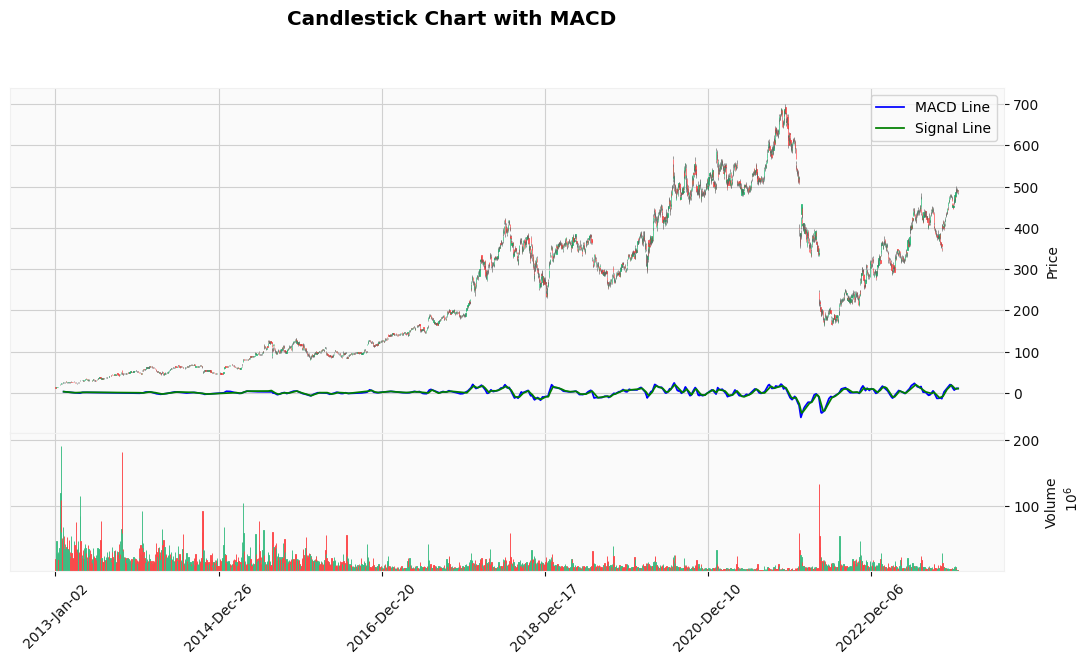

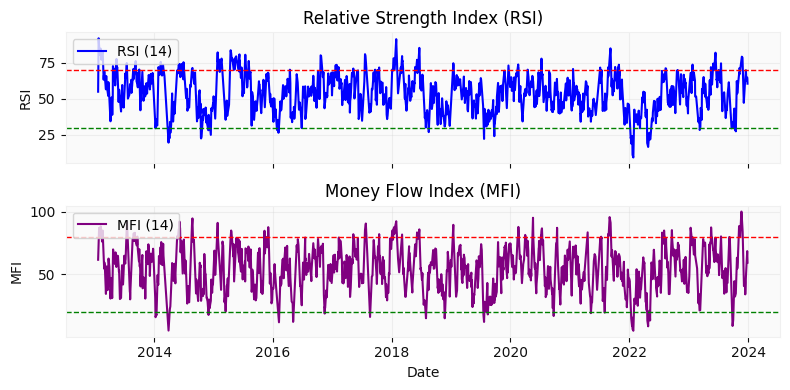

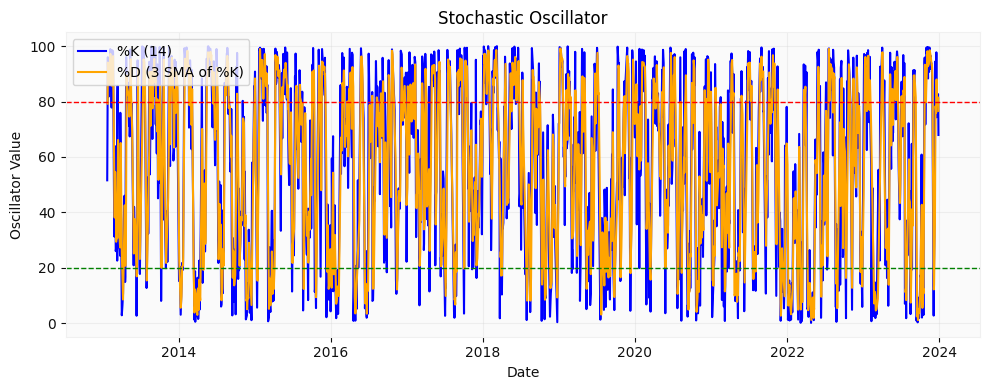

In [ ]:
df_NFLX.index = df_NFLX['Date']

## 1. For the MACD and Signal Line on the candlestick chart
apds = [
    mpf.make_addplot(df_NFLX['MACD'], color='blue', label='MACD Line'),
    mpf.make_addplot(df_NFLX['Signal_Line'], color='green', label='Signal Line')
]

## 2. Plot candlestick chart with volume
mpf.plot(
    df_NFLX,
    type='candle',
    style='yahoo',
    volume=True,
    addplot=apds,
    title="Candlestick Chart with MACD",
    ylabel="Price",
    ylabel_lower="Volume",
    figratio=(8,4),
    figscale=1.2
)

## 3. Plot RSI and MFI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,4), sharex=True)

ax1.plot(df_NFLX['Date'], df_NFLX['RSI'], label='RSI (14)', color='blue')
ax1.axhline(70, color='red', linestyle='--', linewidth=1)   # overbought
ax1.axhline(30, color='green', linestyle='--', linewidth=1) # oversold
ax1.set_title("Relative Strength Index (RSI)")
ax1.set_ylabel("RSI")
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)

ax2.plot(df_NFLX['Date'], df_NFLX['MFI'], label='MFI (14)', color='purple')
ax2.axhline(80, color='red', linestyle='--', linewidth=1)   # overbought
ax2.axhline(20, color='green', linestyle='--', linewidth=1) # oversold
ax2.set_title("Money Flow Index (MFI)")
ax2.set_ylabel("MFI")
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)

# Shared x-axis (Date)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

## 4. Plot Stochastic Oscillator
plt.figure(figsize=(10,4))

plt.plot(df_NFLX['Date'], df_NFLX['%K'], label='%K (14)', color='blue')
plt.plot(df_NFLX['Date'], df_NFLX['%D'], label='%D (3 SMA of %K)', color='orange')

# Overbought / Oversold lines
plt.axhline(80, color='red', linestyle='--', linewidth=1)
plt.axhline(20, color='green', linestyle='--', linewidth=1)

plt.title("Stochastic Oscillator")
plt.ylabel("Oscillator Value")
plt.xlabel("Date")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### <a id='toc2_1_3_'></a>[Other related features](#toc0_)

#### <a id='toc2_1_3_1_'></a>[If the dividends/ split data is not available in the set, we can approximate Adjusted Closing Price to be close to Close Price](#toc0_)

In [ ]:
df_NFLX['Adjusted_Close_Price'] = df_NFLX['Close']

#### <a id='toc2_1_3_2_'></a>[Log Return calculated using Adjusted Close Price](#toc0_)

$$rt​=ln(Pt−1​Pt​​)$$

In [ ]:
df_NFLX["LogRet"] = np.log(df_NFLX["Adjusted_Close_Price"] / df_NFLX["Adjusted_Close_Price"].shift(1))

#### <a id='toc2_1_3_3_'></a>[Realized Volatility](#toc0_)

- Mainly requires Intradays (multiple row per 1 day meaning different prices based on hour bars with frequency 1-min, 5-min, 15-min)

then RV can be calculated by

$$
RV_t = \sqrt{\sum_{i=1}^{M} r_{t,i}^2}
​$$

where $r_{t,i}$ = intraday log return

However, since these are day-by-day market we don't have intradays so we can use these formulas instead

* Parkinson volatility (use High-Low)

$$σ^2 = \frac{1}{4 \ln(2)} \left( \ln \left( \frac{High}{Low} \right) \right)^2$$

* Rogers–Satchell Volatility

$$σ^2 = \ln \left( \frac{High}{Close} \right) \ln \left( \frac{High}{Open} \right) 
+ \ln \left( \frac{Low}{Close} \right) \ln \left( \frac{Low}{Open} \right)$$

In [ ]:
# Parkinson volatility
df_NFLX["ParkinsonVol"] = (1 / (4*np.log(2))) * (np.log(df_NFLX["High"] / df_NFLX["Low"]))**2

# Rogers-Satchell volatility
df_NFLX["RSVol"] = (np.log(df_NFLX["High"]/df_NFLX["Close"]) * np.log(df_NFLX["High"]/df_NFLX["Open"]) +
               np.log(df_NFLX["Low"]/df_NFLX["Close"]) * np.log(df_NFLX["Low"]/df_NFLX["Open"]))


#### <a id='toc2_1_3_4_'></a>[Some Time features like year, Month, weekday](#toc0_)

In [ ]:
df_NFLX['Year'] = df_NFLX['Date'].dt.year
df_NFLX['Month'] = df_NFLX['Date'].dt.month
df_NFLX['Weekday'] = df_NFLX['Date'].dt.weekday

In [ ]:
df_NFLX.head()

,Date,Open,High,Low,Close,Volume,RSI,EMA_12,EMA_26,MACD,...,MFI,%K,%D,Adjusted_Close_Price,LogRet,ParkinsonVol,RSVol,Year,Month,Weekday
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,2013-01-02,13.601429,13.687143,12.955714,13.144286,19431300,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.144286,NaN,0.001088,0.000957,2013,1,2
2013-01-03,2013-01-03,13.138571,13.988571,13.075714,13.798571,27912500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.798571,0.048578,0.001643,0.001115,2013,1,3
2013-01-04,2013-01-04,13.791429,13.958571,13.648571,13.711429,17761100,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.711429,-0.006335,0.000182,0.000263,2013,1,4
2013-01-07,2013-01-07,13.770000,14.535714,13.731429,14.171429,45550400,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.171429,0.032998,0.001169,0.001462,2013,1,0
2013-01-08,2013-01-08,14.287143,14.427143,13.828571,13.880000,24714900,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.880000,-0.020779,0.000648,0.000498,2013,1,1


In [ ]:
df_NFLX.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'EMA_12',
       'EMA_26', 'MACD', 'Signal_Line', 'TP', 'MF', 'PMF', 'NMF', 'PMF_sum',
       'NMF_sum', 'MR', 'MFI', '%K', '%D', 'Adjusted_Close_Price', 'LogRet',
       'ParkinsonVol', 'RSVol', 'Year', 'Month', 'Weekday'],
      dtype='object')

## <a id='toc2_2_'></a>[Clean and Preprocessing](#toc0_)

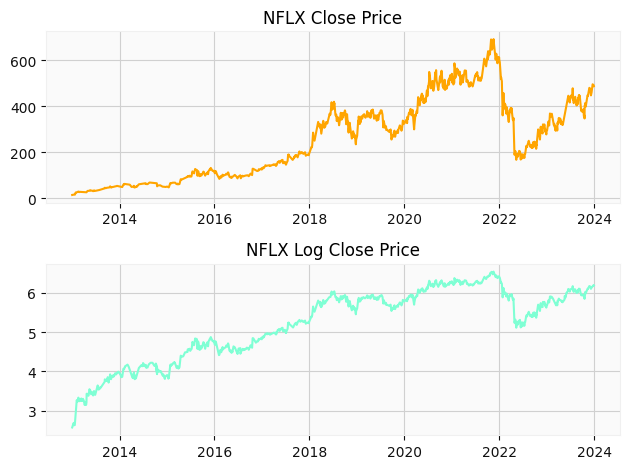

In [ ]:
plt.subplot(2,1,1)
plt.plot(df_NFLX['Date'], df_NFLX['Close'], label='Close_Price', color='orange')
plt.title('NFLX Close Price')

plt.subplot(2,1,2)
plt.plot(df_NFLX['Date'], np.log(df_NFLX['Close']), label='Close_Price', color='aquamarine')
plt.title('NFLX Log Close Price')

plt.tight_layout()
plt.show()

In [ ]:
df_NFLX['Close_log'] = np.log(df_NFLX['Close'])

### <a id='toc2_2_1_'></a>[Check for stationarity of Close price](#toc0_)

In [41]:
### Test for differencing of non-seasonal patterns

def find_d(dataset, col): 
    i = 0
    temp = dataset
    while True:
        result = adfuller(temp[col].dropna())
        if result[1] < 0.05:
            print(f"Number of difference: {i}")
            print('ADF Statistic: %f' % result[0])
            print('p-value: %f' % result[1])
            break
        else:
            temp = temp.diff().dropna()
            i = i+1
            
            if temp[col].isna().all():  # Prevent infinite loop
                print("All values became NaN after differencing. Check data.")
                break
            
find_d(df_NFLX, 'Close')

Number of difference: 1
ADF Statistic: -11.096320
p-value: 0.000000


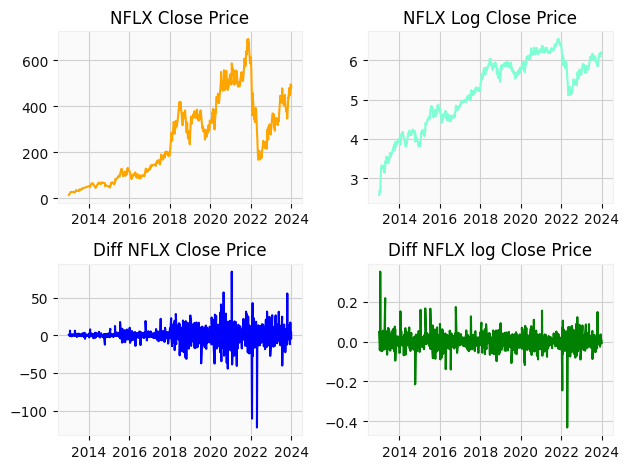

In [ ]:
plt.subplot(2,2,1)
plt.plot(df_NFLX['Date'], df_NFLX['Close'], label='Close_Price', color='orange')
plt.title('NFLX Close Price')

plt.subplot(2,2,2)
plt.plot(df_NFLX['Date'], df_NFLX['Close_log'], label='Close_Price', color='aquamarine')
plt.title('NFLX Log Close Price')

plt.subplot(2,2,3)
plt.plot(df_NFLX['Date'], df_NFLX['Close'] - df_NFLX['Close'].shift(1), label='Close_Price', color='blue')
plt.title('Diff NFLX Close Price')

plt.subplot(2,2,4)
plt.plot(df_NFLX['Date'], df_NFLX['Close_log'] - df_NFLX['Close_log'].shift(1), label='Close_Price', color='green')
plt.title('Diff NFLX log Close Price')

plt.tight_layout()
plt.show()

For raw close price, the original series is not stationary, so we need to take the first differentiation to ensure the stationarity of the data. However, when we first take the log of the price the series itself is stationary and doesn't need another step of differencing to get the P< 0.05 in adf

We still need to apply several tests to see which processing method is more appropriate, here we apply a wider variety of test on the logging of raw series to see whether log is an appropriate approach

#### <a id='toc2_2_1_1_'></a>[Pre-requisites:](#toc0_)
* Unit root (also called a unit root process or a difference stationary process): a stochastic trend in a time series, sometimes called "a random walk with drift", which is an unpredictable pattern occuring in a trend 

The reason why this is called "unit root" is due to the maths behind the process. A process can be written as a series of monomials (expression with a single term). Each monomials correspond to a root, if 1 of the root is 1 then that's a unit root. 

$$yt_​=ρy_{t−1}​+ε_t​, ε_t​∼iid(0,σ^2)$$

Unit root: p = 1 leads to 

$$y_t = y_{t-1} + ε_t$$

=> Non-stationary arises immediately when mean depends on initial values and variance grows with time

In more severe cases, unit root can also lead to 

    - Spurious regression problem: When 2 uncorelated series both have unit roots, regressions between them often appear statistically significant (high $r^2$) even though there’s no real relationship. This can mislead into finding “false” correlations.
    
    - Errant behavior (t-ratios will not follow a t-distribution)

* Return

    - Taking about the change in close Price in subsequent days (like the rise in profit after 1 day)

Simple return can be calculated via
$$R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

Or can be taken by Log difference, which is used in this approach

$$r_t = \ln(P_t) - \ln(P_{t-1}) = \ln\left(\frac{P_t}{P_{t-1}}\right)$$

Tests have proven that these 2 approaches yield approximately similar results, but the log difference is more relevant to the term of differencing and logging, which helps in stationarity

#### <a id='toc2_2_1_2_'></a>[Augmented Dickey-Fuller Test (ADF test):](#toc0_)

Defines the stationary zone in a normal distribution and the series is stationary if the value is inside the rejection zone (5% significant level 2 tails)

Look at the P-value, if P < threshold then it's stationary, if P > threshold then it's non-stationary
#### <a id='toc2_2_1_3_'></a>[Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):](#toc0_)

Check if a series is stationary around a deterministic trend or mean, versus being non-stationary with a unit root
This is different from the ADF where
- H0: Data is stationary
- H1: Data is not stationary

The KPSS test is based on linear regression. It splits the data into 3 parts: a deterministic trend ($β_t$), a random walk ($r_t$), and a stationary error ($ε_t$), with the regression equation:

$$xt = r_t + β_t + ε_1$$

If the data is stationary, it will have a fixed element for an intercept or the series will be stationary around a fixed level. Data is normally log-transformed before running the KPSS test, to turn any exponential trends into linear ones.

Look at the P-value, if P-value < threshold then it's not stationary, if large, > threshold then it's stationary

#### <a id='toc2_2_1_4_'></a>[Ljung-Box Test](#toc0_)

The Ljung-Box test is a statistical test that checks for autocorrelation (serial correlation) in a time series by testing if a group of autocorrelations, up to a specified lag, are significantly different from 0. The test uses a Q-Statistic and a p-value to assess the overall randomness of a time series

Overall, the test calculates a Q statistics, which is then compared to a chi-square distribution to derive a p-value

If P-value < thresold, then suggest the presence of significant autocorrelation in the time series, meaning it's not white noise. If P > threshold, then the series can be considered random or IID (independent and identically distributed)

The test-statistic is: 

$$Q(m) = T(T+2) \sum_{k=1}^{m} \frac{\hat{\rho}_k^{2}}{T-k}$$

Where: 
T = sample size

m = number of lags

Under the null (no autocorrelation), Q(m) ~ $X^2_{m-p-q}$ where p, q are ARMA orders if testing residuals

#### <a id='toc2_2_1_5_'></a>[ARCH test](#toc0_)

In [34]:
s = df_NFLX['Close'].dropna()          # raw price
log_s = np.log(s)
log_ret = log_s.diff().dropna()

def adf_report(x, name="series"):
    stat, p, nlags, nobs, crit, icbest = adfuller(x, regression='c', autolag='AIC')
    print(f"{name}: ADF stat={stat:.3f}, p={p:.3f}, nlags={nlags}")

def kpss_report(x, name="series"):
    stat, p, lags, crit = kpss(x, regression='c', nlags='auto')
    print(f"{name}: KPSS stat={stat:.3f}, p={p:.3f}")

adf_report(log_s, "log-level")
adf_report(log_ret, "log-returns")
kpss_report(log_s, "log-level")
kpss_report(log_ret, "log-returns")

# diagnostics on returns
print("Ljung-Box (returns):", acorr_ljungbox(log_ret, lags=[10, 20], return_df=True))
print("ARCH test (returns):", het_arch(log_ret))


log-level: ADF stat=-3.003, p=0.035, nlags=0
log-returns: ADF stat=-35.830, p=0.000, nlags=1
log-level: KPSS stat=7.413, p=0.010
log-returns: KPSS stat=0.364, p=0.093
Ljung-Box (returns):       lb_stat  lb_pvalue
10  19.426907   0.035164
20  29.460678   0.079077
ARCH test (returns): (8.044977525621029, 0.6244434695434269, 0.8036329479654525, 0.6252935161844305)


C:\Users\admin\AppData\Local\Temp\ipykernel_23428\811781059.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(x, regression='c', nlags='auto')


From this, although taking the log price does reduce noise and exponential trend rise, the log still suffers from a relatively low KPSS value, indicating high non-stationarity, while the ADF is only slightly low.

In Ljung-box test, at lag 10 p < 0.05 which still shows some structure, but in lag 20, the p-value > 0.05 which marks for white-noise and no clear autocorrelation. This shows short-memory dependence (try smaller p and q in ARMA)

In [ ]:
df_NFLX['Close_diff'] = df_NFLX['Close'] - df_NFLX['Close'].shift(1)

df_NFLX['Close_log'] = np.log(df_NFLX['Close'])

df_NFLX['Return'] = np.log(df_NFLX['Close']) - np.log(df_NFLX['Close'].shift(1))

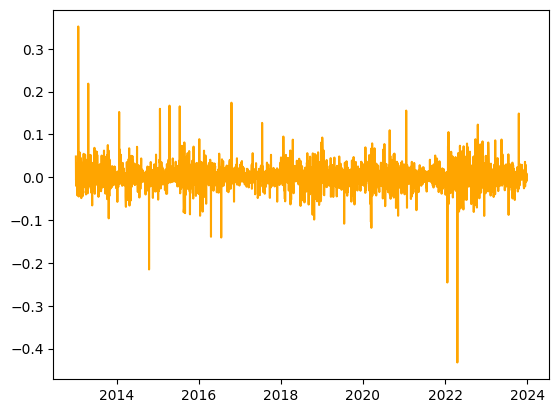

In [40]:
plt.plot(df_NFLX['Date'], df_NFLX['Return'], label='Return', color='orange')

In [42]:
find_d(df_NFLX, 'Return')

Number of difference: 0
ADF Statistic: -35.830437
p-value: 0.000000


Test Statistics much smaller than normal Differencing; However, we pick the appropriate variable based on need

* If forecast price or price analysis, we need to use Price

* If forecast expected return or analyzing volatility, we can use Return

### <a id='toc2_2_2_'></a>[Other methods](#toc0_)

#### <a id='toc2_2_2_1_'></a>[Box-Cox Transform](#toc0_)

- Box-Cox Transform offers a systematic way transform non-normal data into a form that better approximates normality, stabilizes variance and enhances the applicability of methods that rely on normality assumptions. It's particularly used for positively skewed data such as financial metrics, biological measurement or time-to-event data

The Box-Cos transformation is defined as :
$$y(\lambda) =
\begin{cases}
\dfrac{y^{\lambda} - 1}{\lambda}, & \text{if } \lambda \neq 0 \\
\log(y), & \text{if } \lambda = 0
\end{cases}$$

Where: y is the original data-point

$\lambda$ is the transformation param, this is selected by the maximize of log-likelihood function

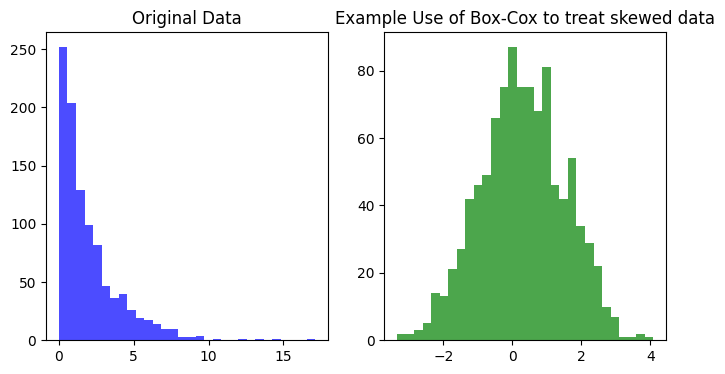

In [53]:
np.random.seed(0)
data = np.random.exponential(scale=2, size=1000)

transformed_data, lambda_opt = stats.boxcox(data)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(data, bins=30, color='blue', alpha=0.7)
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins=30, color='green', alpha=0.7)
plt.title('Example Use of Box-Cox to treat skewed data')

plt.show()

In [ ]:
df_NFLX['BC_Price'], lambda_opt = stats.boxcox(df_NFLX['Close'])

In [50]:
print(f"Optimal Lambda: {lambda_opt}")

Optimal Lambda: 0.3922703124466972


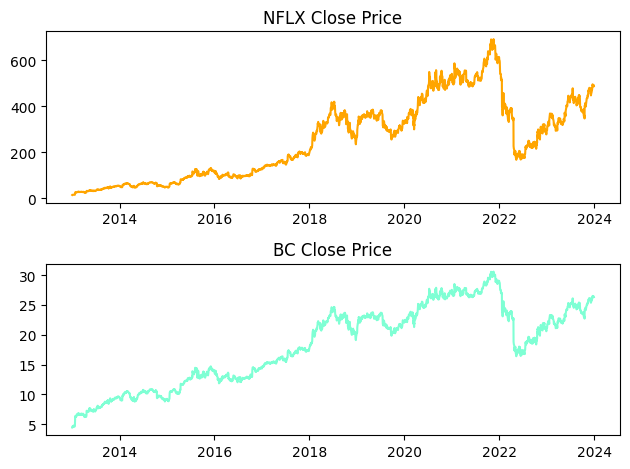

In [49]:
plt.subplot(2,1,1)
plt.plot(df_NFLX['Date'], df_NFLX['Close'], label='Close_Price', color='orange')
plt.title('NFLX Close Price')

plt.subplot(2,1,2)
plt.plot(df_NFLX['Date'], df_NFLX['BC_Price'], label='BC', color='aquamarine')
plt.title('BC Close Price')

plt.tight_layout()

The skewness and variance has been reduced by compressing values down to lower scale. However, we just need to use Box-Cox when the series has a changing variance and highly skewed (e.g volatility grows with price level -> like stocks), otherwise, just use normal differencing.

#### <a id='toc2_2_2_2_'></a>[Yeo/Johnson Transform](#toc0_)

Yeo-Johnson Transform is an extension of Box-Cox Transform, but unlike Box-Cox, it can handle both positive and negative values. This is especially useful in data processing for ML models and require normally distributed or symmetrically distributed data, such as linear regression or PCA.

Y-J Transformation is defined piecewise depending on whether the input value y is non-negative or negative. The transformation T(y; $\lambda$) is defined by:

$$T(y;\lambda) =
\begin{cases}
  \dfrac{(y+1)^{\lambda} - 1}{\lambda}, & \text{if } \lambda \neq 0 \\[1em]
  \log(y+1), & \text{if } \lambda = 0
\end{cases}
\quad \text{for } y \geq 0$$

$$T(y;\lambda) =
\begin{cases}
  -\dfrac{(-y+1)^{2-\lambda} - 1}{2-\lambda}, & \text{if } \lambda \neq 2 \\[1em]
  -\log(-y+1), & \text{if } \lambda = 2
\end{cases}
\quad \text{for } y < 0$$

As an improvement of Box-Cox, the Y-H Transform works for all real-valued inputs. The function is continuous and differentiable w.r.t both y and $\lambda$, the function is reversible via built-in function and the param $\lambda$ can also be utilized by using max-likelihood. USing Y-J can imporve the effectiveness of PCA by ensuring more uniform variances

In [ ]:
y_h_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

df_NFLX['YJ_Price'] = y_h_transformer.fit_transform(df_NFLX[['Close']])

#### <a id='toc2_2_2_3_'></a>[Also try naive Standard Scaling](#toc0_)

In [ ]:
df_NFLX['Standard_Close'] = StandardScaler().fit_transform(df_NFLX[['Close']])

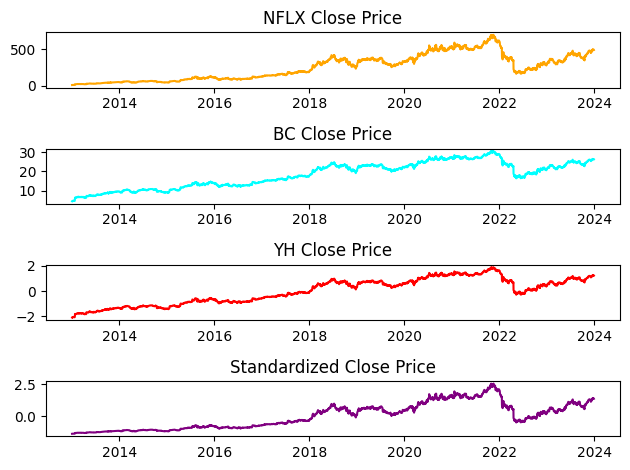

In [67]:
plt.subplot(4,1,1)
plt.plot(df_NFLX['Date'], df_NFLX['Close'], label='Close_Price', color='orange')
plt.title('NFLX Close Price')

plt.subplot(4,1,2)
plt.plot(df_NFLX['Date'], df_NFLX['BC_Price'], label='BC', color='cyan')
plt.title('BC Close Price')

plt.subplot(4,1,3)
plt.plot(df_NFLX['Date'], df_NFLX['YJ_Price'], label='YJ', color='red')
plt.title('YH Close Price')

plt.subplot(4,1,4)
plt.plot(df_NFLX['Date'], df_NFLX['Standard_Close'], label='YH', color='purple')
plt.title('Standardized Close Price')

plt.tight_layout()

Although these look pretty similar, only a mild differences in the scale and respective variance, we have to differentiate for each use case realated to Close Price:

* If use Classical Forecasting (AR-I-MA, ETS) then Box-Cox is usually best due to easy inversion back to actual value

* If use ML or DL models then Yeo-Johnson or Standardize are better, but Y-J still ensures distribution closer to normal


### <a id='toc2_2_3_'></a>[Denoising](#toc0_)

#### <a id='toc2_2_3_1_'></a>[Moving Average (MA) or Smoothing Kernel](#toc0_)

One of the most classical technique is to use Moving Average, which is fitting a moving window to return the mean value over a predefined window range. The wider the moving window, the smoother the series. However, this technique contains several significant backlashes

* Information - Smoothness Tradeoff: Choose a wide moving window smooths out fluctuations, but they also remove significant short-term trends and potential patterns: This is critical in cases where multiple signals can be captured in short term conditions.

* Lag Effect: MA causes the data to deeply depend on past data, the wider the window, the greater the lag, thus losing the current market momentum

* Hard to optimize the window size: Fixed size introduces a risk of not optimally fitting into the series => Risk sacrificing patterns

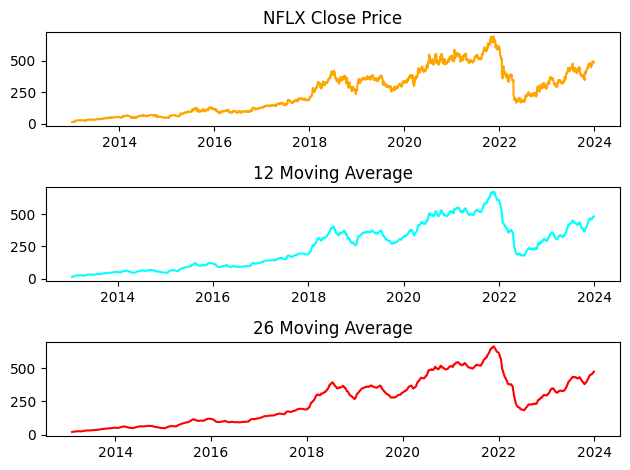

In [74]:
plt.subplot(3,1,1)
plt.plot(df_NFLX['Date'], df_NFLX['Close'], label='Close_Price', color='orange')
plt.title('NFLX Close Price')

plt.subplot(3,1,2)
plt.plot(df_NFLX['Date'], EMA(df_NFLX['Close'], 12), label='BC', color='cyan')
plt.title('12 Moving Average')

plt.subplot(3,1,3)
plt.plot(df_NFLX['Date'], EMA(df_NFLX['Close'], 26), label='BC', color='red')
plt.title('26 Moving Average')

plt.tight_layout()

Another approach is to use a Gaussian smoothing kernel to smooth the data, it works by applying a Gaussian function to each point in the data and weighting its surrounding points, the closer a point is to the current data point, the higher the weight it receives

The Gaussian kernel is also a common smoothing technique in Image processing

The Gaussian function is given by:
$$G(x) = \dfrac{1}{\sqrt{2\pi \sigma^2}} \exp\left( -\dfrac{x^2}{2\sigma^2} \right)
$$

where: 
* $\sigma$ is the stddev, this parameter can be modified based on expectation of data points
* x is the distance from the center of the kernel (from the current data point)

The generated weights are based on normal distribution (using mean and stddev)

Gaussian smoothing preserves important patterns like edges and sharp changes better, less sensitivity to outliers and ideal for Gaussian-like data. However, this is still not robust to unexpected patterns in series, especially in high variant data like Stock and works best with Normally-distributed data

C:\Users\admin\AppData\Local\Temp\ipykernel_23428\2195922712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NFLX['Gaussian_smoothed_Price'] = gaussian_filter1d(df_NFLX['Close'], sigma=2)


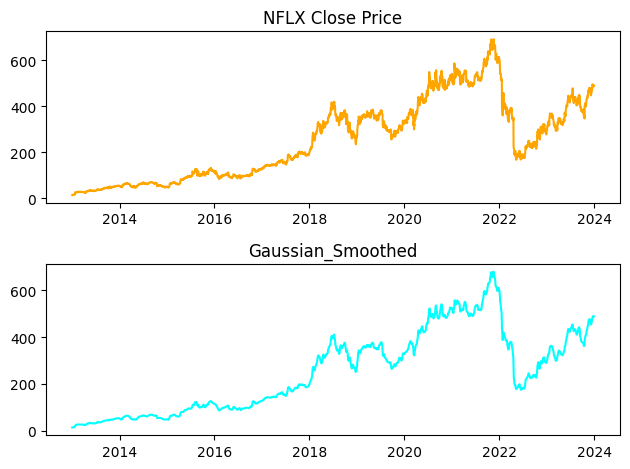

In [76]:
df_NFLX['Gaussian_smoothed_Price'] = gaussian_filter1d(df_NFLX['Close'], sigma=2)

plt.subplot(2,1,1)
plt.plot(df_NFLX['Date'], df_NFLX['Close'], label='Close_Price', color='orange')
plt.title('NFLX Close Price')

plt.subplot(2,1,2)
plt.plot(df_NFLX['Date'], df_NFLX['Gaussian_smoothed_Price'], label='BC', color='cyan')
plt.title('Gaussian_Smoothed')

plt.tight_layout()

#### <a id='toc2_2_3_2_'></a>[Seasonal-Time decomposition with LOESS (STL)](#toc0_)

Additional Approach: Seasonal Decomposition 

Seasonal_Decompose is a function in the statsmodels library which mainly helps with the associated AR-I-MA models. The function decomposes a time series into 3 components:
* Trend: The long term movement in the data, such as gradual increase/ decrease over time, this is regarded as a smoothed version of the series

* Seasonal: The repeating patterns/ cycles in the data that occur at regular intervals (daily, weekly, yearly). If there is seasonal pattern in the data, a clear repeating linear pattern can be observed in the Seasonal component

* Residual: The noise or irregular component that's left after the trend and seasonal components are removed. Ideally this is centered around 0, meaning normality of residuals.

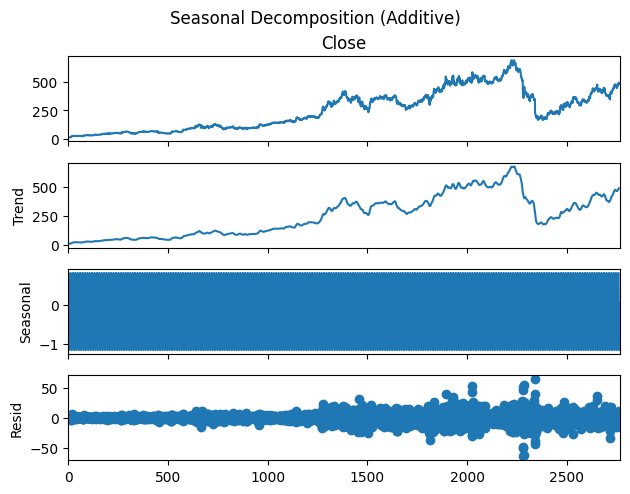

In [78]:
result = seasonal_decompose(df_NFLX['Close'], model='additive', period=12) 

result.plot()
plt.suptitle('Seasonal Decomposition (Additive)', y=1.02)
plt.show()

In this graph, due to lack of seasonal pattern of the data, the Seasonal component is currently full and doesn't show any viewable pattern

The STL utilizes Locally (Weighted) Scatterplot Smoothing (LOESS), which is a non-parametric regression method used for smoothing data. 

LO(W)ESS both work by fitting a local regression models to estimate the value of 1 point based on nearby points, assigning weights to a OLS (or Gaussian kernel) based on their distance from $x_i$.

For example: window_size = 5

$x_2$ can be regressed based on $x_1, x_3, x_4, x_5$ in which $x_1$ and $x_3$ receive higher weight due to being closer to the current point.

The main difference between LOESS and LOWESS is their use of regression kernel.
* LOESS is a general version of local regression and can use different kernel functions and high-degree polynoms for the local fiting (quadratic/ rubic)
* LOWESS is a specific case where a linear kernel (weighted linear regression) is used for the model, this typically uses linear smoothing with less computational complexity.

An improvement of STL over tradtional ST Decomposition is the use of LOESS in the estimation of trend and seasonal components, where a specific local polynomials regression model is fitted to iteratively update the components.

However, some major backlashes of this approach can include the computational complexity (due to using polynomials fitting) and the window size sensitivity, which is also faced in previous approaches

In [ ]:
stl = STL(df_NFLX['Close'], period=12, robust=True) #assuming yearly seasonal pattern

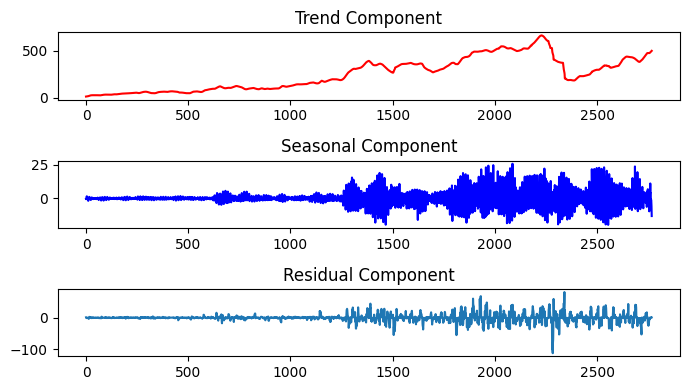

In [96]:
result = stl.fit()

# Plot the decomposition components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 4))

ax1.plot(df.index, result.trend, label='Trend', color='red')
ax1.set_title('Trend Component')
ax2.plot(df.index, result.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(df.index, result.resid, label='Residual')
ax3.set_title('Residual Component')
plt.tight_layout()
plt.show()

Due to the use of LOESS, the seasonal component is more remarkable, as compared to the traditional Seasonal Decomposition.

In [3]:
# df_NFLX.to_csv('D:/Study/Education/Projects/OmniTS/data/temp.csv')

df_NFLX = pd.read_csv('D:/Study/Education/Projects/OmniTS/data/temp.csv')

#### <a id='toc2_2_3_3_'></a>[Hodrick-Prescott Filter (HP Filter)](#toc0_)

The Hodrick-Prescott Filter (HP Filter) is a data smoothing technique which works well with low-frequency data (annual, quarterly). The HP filter is commonly applied during analysis to remove short-term fluctuations associated with the business cycle to reveal long-term trends, mostly used in macroeconomics and time series data like GDP, inflation or unemployment.

The HP filter works by decomposing a time series $y_t$ into 2 components:
* Trend component $\hat{y}_t$
* Cyclical Component $c_t$

The goal is to minimize the objective function: 

$$\min_{\hat{y}_t} \sum_{t=1}^{T} \left( y_t - \hat{y}_t \right)^2 + \lambda \sum_{t=2}^{T-1} \left[ \left( \hat{y}_{t+1} - \hat{y}_t \right) - \left( \hat{y}_t - \hat{y}_{t-1} \right) \right]^2$$

Where:

* $y_t$ is the original series at time t
* $\hat{y}_t$ is the trend component at time t
* $c_t = y_t - \hat{y}_t$
* $\lambda$ is the smoothing param that controls the degree of smoothness of the trend. A larger value of $\lambda$ results in a smoother trend, while a smaller value allows for more fluctuations in the trend component. (Typically set to 1600 for quarterly data - suggested by author, 100 for annual data or 6.25 for monthly data)

The objective function has 2 parts:

* First term minimizes the difference between the observed series $y_t$ and the trend $\hat{y}_t$
* Second term penalizes large fluctuations in the trend by adding a penalty for large changes in the trend's slope.

Larger $\lambda$ value result in a smoother trend, but may suppress short-term fluctuations while smaller value allow for more variations and better suited for data with short-term cycles. This marks the main challenge of this approach, which is the choice of parameter

d:\Study\Setup\anaconda\config\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


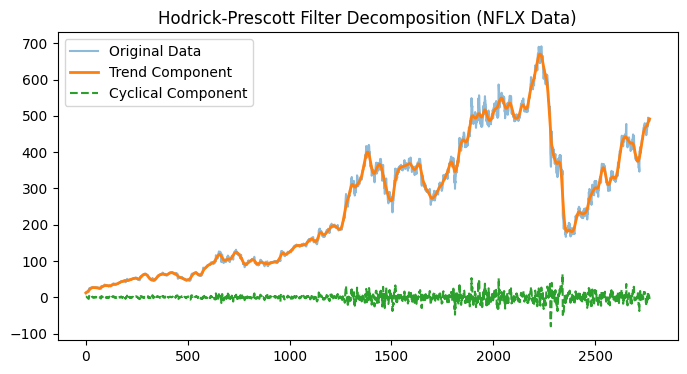

In [6]:
cycle, trend = hpfilter(df_NFLX['Close'], lamb=1600)  # Use the appropriate lambda value based on data frequency

plt.figure(figsize=(8, 4))
plt.plot(df_NFLX.index, df_NFLX['Close'], label='Original Data', alpha=0.5)
plt.plot(df_NFLX.index, trend, label='Trend Component', linewidth=2)
plt.plot(df_NFLX.index, cycle, label='Cyclical Component', linestyle='--')
plt.title('Hodrick-Prescott Filter Decomposition (NFLX Data)')
plt.legend()
plt.show()

#### <a id='toc2_2_3_4_'></a>[Savitzky - Golay Filter (SG Filter)](#toc0_)

#### <a id='toc2_2_3_5_'></a>[Kalman Filters](#toc0_)

#### <a id='toc2_2_3_6_'></a>[Wavelet shrinkage](#toc0_)

#### <a id='toc2_2_3_7_'></a>[Fourier Transform](#toc0_)

#### <a id='toc2_2_3_8_'></a>[Empirical Mode Decomposition (EMD)](#toc0_)

### <a id='toc2_2_4_'></a>[Dealing with Nulls and Missing data](#toc0_)

#### <a id='toc2_2_4_1_'></a>[Forward/ Back fills](#toc0_)

#### <a id='toc2_2_4_2_'></a>[Hampel filter](#toc0_)

#### <a id='toc2_2_4_3_'></a>[Winsorization](#toc0_)

#### <a id='toc2_2_4_4_'></a>[Robust z-score](#toc0_)